# Exercise Sheet No. 8

---

Machine Learning for Natural Sciences, Summer 2021, Jun.-Prof. Pascal Friederich, pascal.friederich@kit.edu
 
Deadline: 20.06.2022, 8 am

Tutor: andre.eberhard@kit.edu 

**Please ask questions in the forum and only contact the tutor when there are issues with the grading**

---
**Topic**: This assignment will focus on convolutional neural network for brain tumor image classification.

# Preliminaries
In this assginment, we are going to use Pytorch instead of Tensorflow to build our neural network.

In [73]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from PIL import Image
from matplotlib.pyplot import MultipleLocator
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


For the purpose of autograding, please:
1. Set `do_training=True` while finishing this assignment.
2. Please submit your solution with `do_training = False`.

In [74]:
# Please submit your solution with do_training = False.
do_training = False
# YOUR CODE HERE
#do_training=True

In the last assignments, we have implemented and trained fully connected neural networks with applications in chemistry and materials science. This time, we will learn to implement and train a convolutional neural network (CNN) for brain tumor image classification, and compare it with a fully connected neural network to show the power of convolutional filters. In addition to that, we will see how a pretrained network can be used to fulfill the same task with better performance through transfer learning.

# Dataset
In this assignment, we will work with images of brain x-rays from both healthy people and cancer patients.

A brain tumor occurs when abnormal cells form within the brain for unknown reasons. And primary brain tumors occur in around 250,000 people a year globally, making up less than 2% of cancers. The early diagnosis is important when fighting this disease, and medical imaging plays a central role in this field. You may read more about brain tumor from this [paper](https://pubmed.ncbi.nlm.nih.gov/27157931/).

This data set was downloaded from [kaggle](https://www.kaggle.com/preetviradiya/brian-tumor-dataset), and only 10% of cancer/not cancer images were selected randomly for this assignment (460 images in total). Now, let's get started with visualizing part of the dataset.

In [75]:
img_dir = os.path.abspath('dataset')  # path of image directory
images = os.listdir(img_dir)

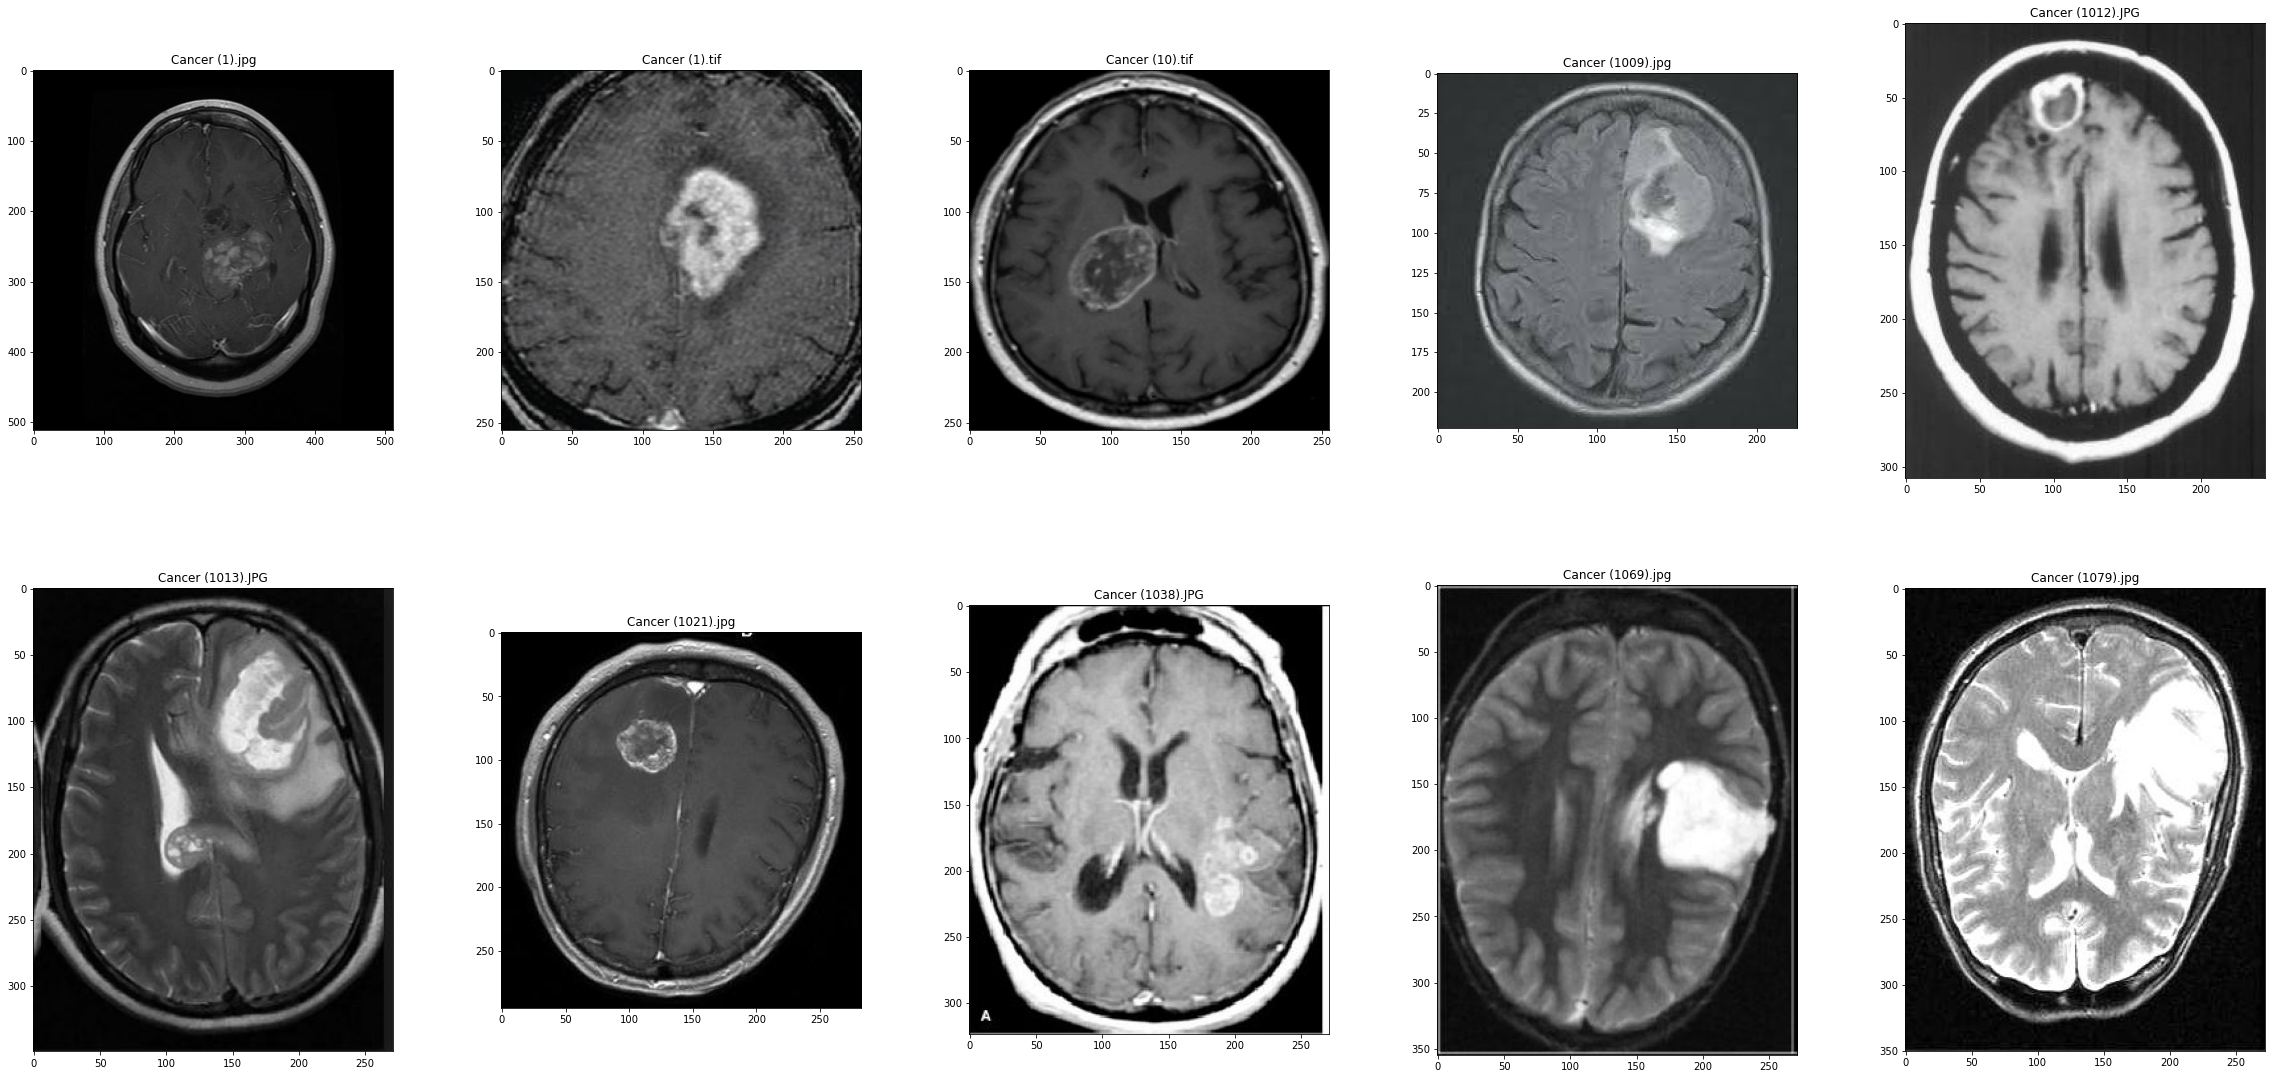

In [76]:
# plot 10 x-ray images
fig, axes = plt.subplots(2, 5, figsize=(40, 20), gridspec_kw=dict(hspace=0.1, wspace=0.3))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(Image.open(os.path.join(img_dir, images[i])))
    ax.set_title(images[i])

## Principal Component Analysis (PCA)
From the plot above we can see that images in the dataset vary by several features, such as brightness, orientation, and of course whether they have a tumor or not. For such a complicated dataset, is it possible to classify it with a simple classifier like k-nearest neighbors? Principal Component Analysis can give us a hint on this problem.

PCA is an unsupervised technique to project the data to lower dimensional space through linear (linear PCA) or non-linear (kernel PCA) combinations of the data's original features. The "Principal Component" stands for combination results of features that account for most of a dataset's variance. PCA can also be used to visualize high-dimensional data, filter out noise, or as feature representation. Here, we will take this advantage to visualize the most significant features in our dataset.

In [77]:
# prepare data in numpy array for PCA()
data = [Image.open(os.path.join(img_dir, i)).convert('L').resize((256, 256)) for i in images]
data = np.array([np.array(d).reshape(-1) for d in data])

Please use the `PCA()` to perform principal component analysis on `data`. Use the parameter `n_components` to set the amount of variance that needs to be explained to be 0.8.

In [78]:
pca = None

# YOUR CODE HERE
pca = PCA(n_components=0.8).fit(data)

In [79]:
assert isinstance(pca, PCA), "pca should be an instance of the sklearn PCA"

Now, let's visualize the images associated with the first several principal components, which may give us some insight about what make these images vary from each other.

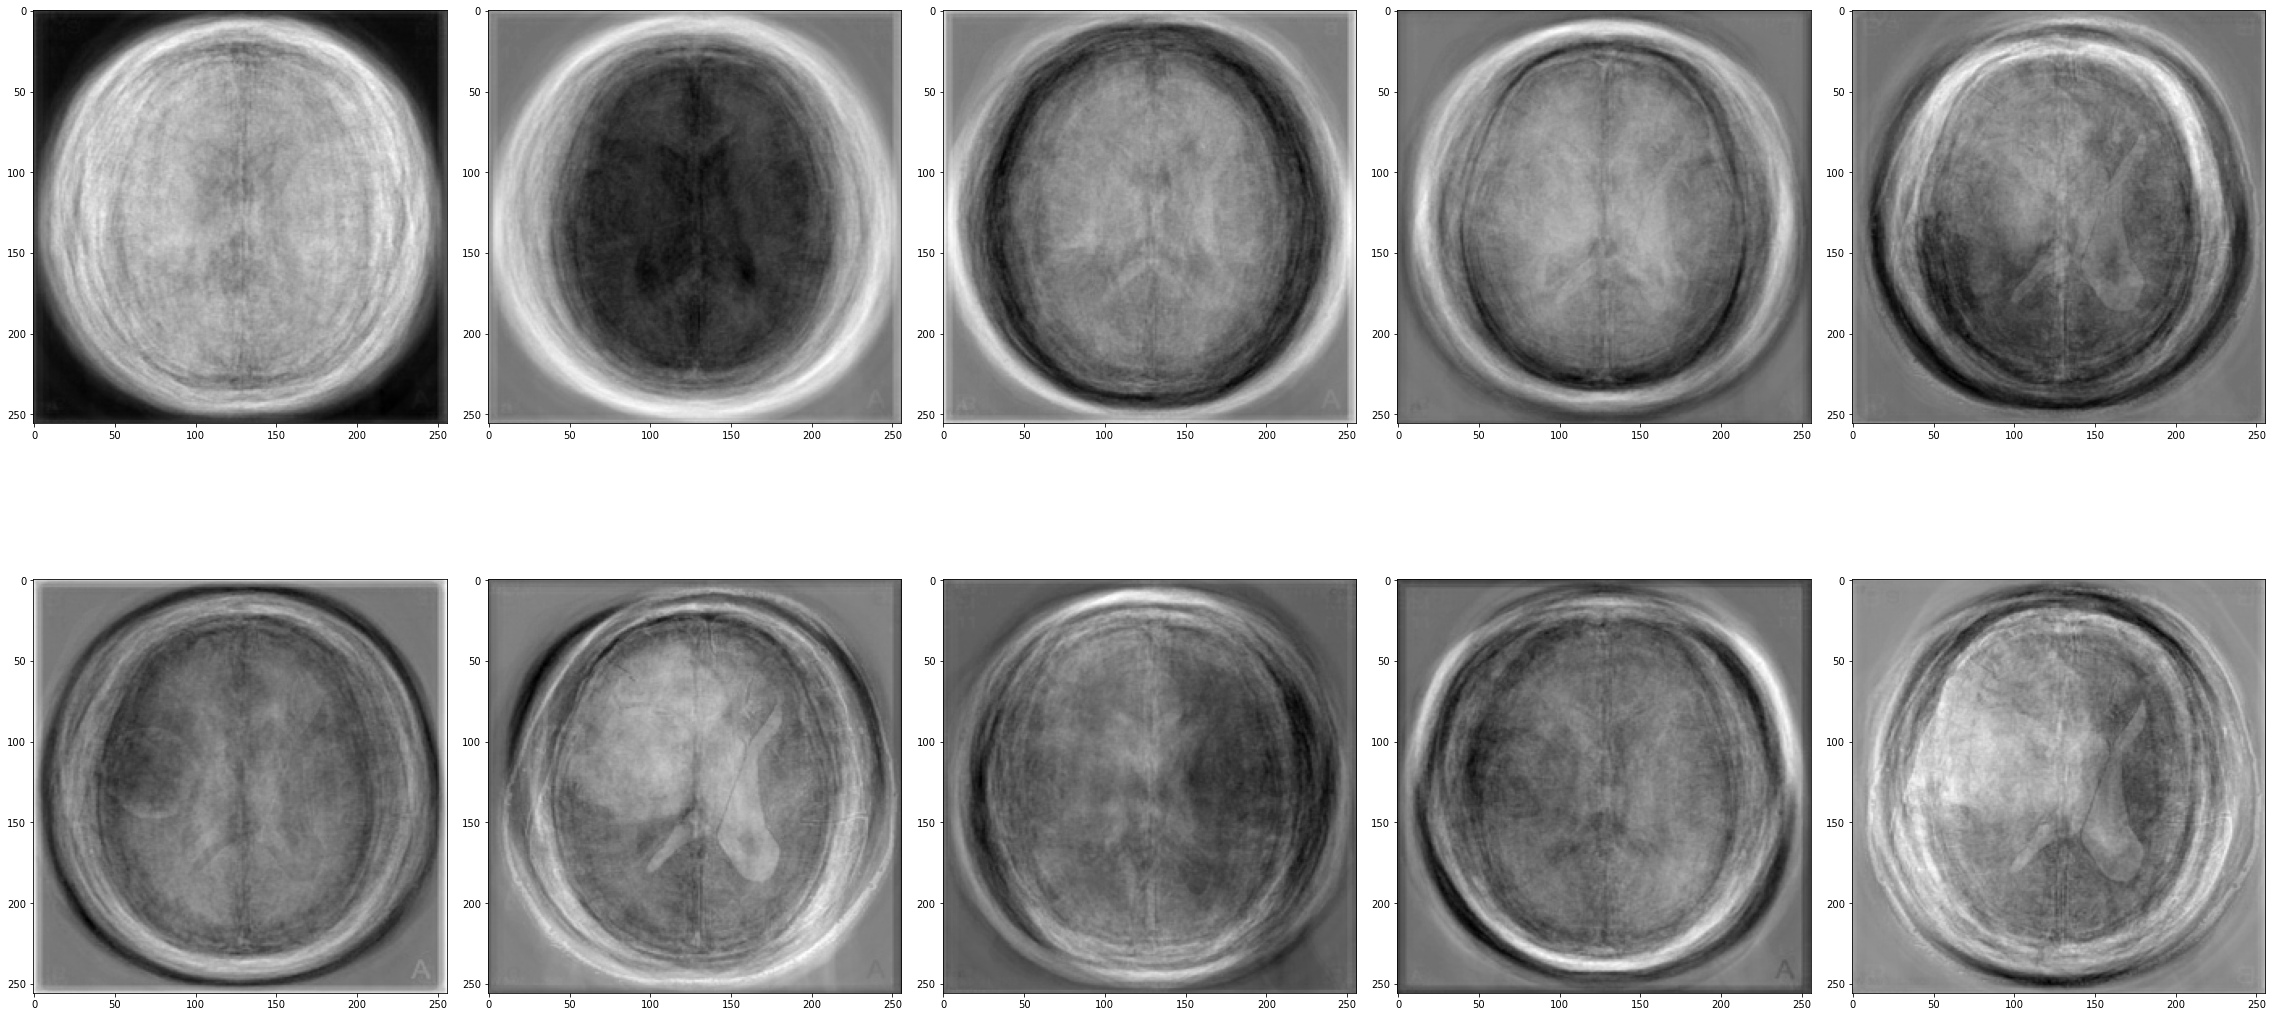

In [80]:
# visualize the first 10 principal components
fig, axes = plt.subplots(2, 5, figsize=(40, 20), gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(pca.components_[i].reshape(256, 256), cmap='gray')

As can be seen above, the first two images on the top left seem to be associated with the brightness of the x-ray image, while the later ones on the bottom right seem related to the direction or size of the skull. Since none of them displays strong relationship to the shape/size/location of the brain tumor, it is difficult to classify cancer/not cancer images with a simple algorithm, which may focus more on those more 'obvious' features. As a result, a more sophisticated model like a neural network is more suitable for this task.

## Data processing
To begin with, we need to obtain and organize all image metadata with `pandas`. Please use `pd.Series` for `img_names` and `img_labels`, together with `pd.concat()` and `pd.DataFrame` to construct `tumor_df`.

In [81]:
# implement tumor_df as pd.DataFrame for train/test split and further data process
tumor_df = None
img_names, img_labels = zip(*[(i, 0 if 'Not Cancer' in i else 1) for i in images])

# YOUR CODE HERE
tumor_df = pd.concat([pd.Series(img_names), pd.Series(img_labels)], axis=1, keys=['name', 'label'])
tumor_df

name  label
0           Cancer (1).jpg      1
1           Cancer (1).tif      1
2          Cancer (10).tif      1
3        Cancer (1009).jpg      1
4        Cancer (1012).JPG      1
..                     ...    ...
455  Not Cancer  (958).jpg      0
456   Not Cancer  (96).jpg      0
457  Not Cancer  (965).jpg      0
458  Not Cancer  (981).jpg      0
459  Not Cancer  (995).jpg      0

[460 rows x 2 columns]

In [82]:
assert len(tumor_df) == 460, 'Please check the set up of tumor_df'
assert tumor_df["label"].value_counts()[1] == 252
assert tumor_df["label"].value_counts()[0] == 208

Now, for the training/test set generation, please use the `train_test_split()` to split the `tumor_df` into `train_set` and `test_set`. This time, we will use 80% of the data for training and the rest for testing.

Please fix the `random_state` to 0.

In [83]:
# training set/test set split
train_set, test_set = None, None

# YOUR CODE HERE
train_set, test_set = train_test_split(tumor_df, train_size=0.8, random_state=0)

In [84]:
# train-test split 1 point
assert train_set.shape == (368, 2)
assert test_set.shape == (92, 2)

Pytorch offers convenient APIs for handling data: `Dataset` and `DataLoader`, which achieve data loading/processing with better readability and modularity. Take the following implementation as an example. Note that this implementation is only for demonstrational purposes. Since our data fits into memory, a more performant implementation would would use a `TensorDataset` or cache images. Repetitively loading samples from disk is inefficient and slows down training significantly.

In [85]:
class TumorImageDataset(Dataset):
    """load, transform and return image and label"""

    def __init__(self, annotations_df, img_dir, transform=None):
        self.img_labels = annotations_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # get image path according to idx
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # convert all image to RGB format
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        # apply image transform
        if self.transform:
            image = self.transform(image)
        return [image, label]

Please finish the `image_transform` module. The image should be resized to $256\times 256$ then cropped at center to size $244 \times 244$. You may use `transforms.Resize()` and `transforms.CenterCrop()` for this task.

In [86]:
# user defined image transform process
# here we resize and cut the center of each image to obtain a dataset with uniform size
image_transform = transforms.Compose([
    # YOUR CODE HERE
    transforms.Resize(256),
    transforms.CenterCrop(244),
    transforms.ToTensor()
])

In [87]:
# implement Dataset and DataLoader for training
train_data = TumorImageDataset(train_set, img_dir, image_transform)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=False)

test_data = TumorImageDataset(test_set, img_dir, image_transform)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

image_datasets = {'train': train_data, 'test': test_data}
image_dataloaders = {'train': train_dataloader, 'test': test_dataloader}

In [88]:
feat, labels = next(iter(train_dataloader))
assert feat.shape[2] == 244 and feat.shape[3] == 244, "Wrong size, please check image_transform"

Here is a plot for part of the dataset with `train_dataloader`.

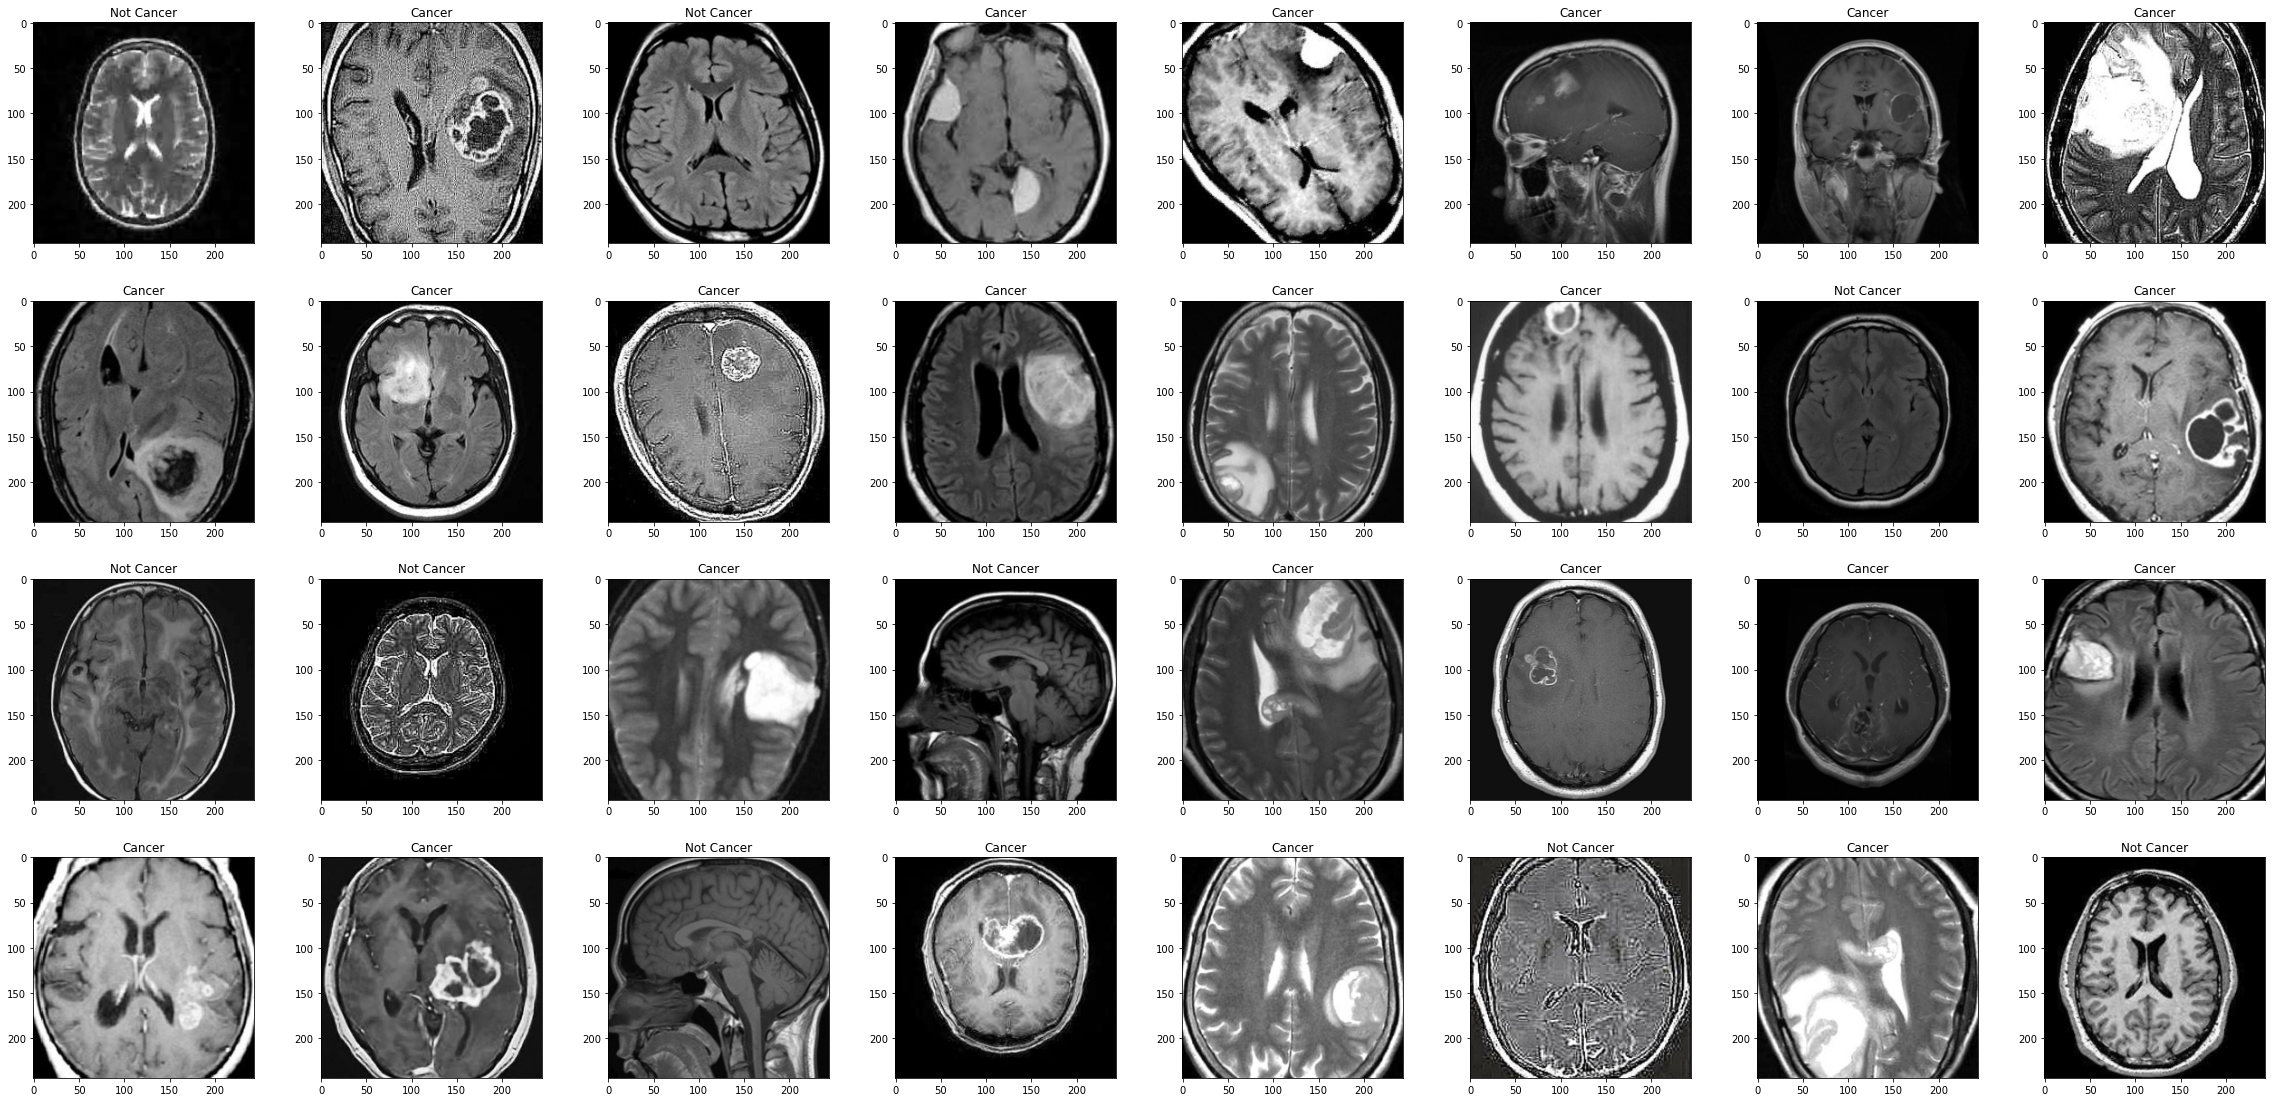

In [89]:
# plot a batch (32) of image in training set
train_features, train_labels = next(iter(train_dataloader))  # DataLoader is iterable
fig, axes = plt.subplots(4, 8, figsize=(40, 20), gridspec_kw=dict(hspace=0.1, wspace=0.3))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_features[i].numpy().transpose((1, 2, 0)))
    ax.set_title('Cancer' if int(train_labels[i] == 1) else 'Not Cancer')

# Build the neural network
## motivation of CNN: compare with fully connected layers
As discussed in the class, an advantage of convolutional neural network (CNN) is weight-sharing of filter parameters. Let's demonstrate this effect by looking at a densely connected NN.

Pytorch builds neural network by subclassing the `nn.Module`. For each `nn.Module`, there is a `forward()` method implementing operations on input data.

We implement the `MultiLayerPerceptron` with three fully connected layers. Please finish the `forward()` method function using `self.fc1`, `self.fc2`, `self.fc3` that have already been already defined. For the first two layers, there is a `F.relu()` activation function for each of them. For the output layer, we use `torch.sigmoid()` to generate outcome between 0 and 1.

In [90]:
class MultiLayerPerceptron(nn.Module):
    """A three layer fully connected neural network"""

    def __init__(self):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(in_features=244 * 244 * 3, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        """Operations on x"""
        x = torch.flatten(x, 1)
        # YOUR CODE HERE
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [91]:
mlp_model = MultiLayerPerceptron().to(device)

assert len(mlp_model.state_dict().keys()) == 6, 'please check if there is any fc layer mising in forward()'


Unfortunately, Pytorch does not support the build-in method to display model information (such as the `summary()` method in Tensorflow). Luckily this can be easily implemented. Here is an example:

In [92]:
def summary(model):
    """Print out model architecture infomation"""
    parameter_count = 0
    model_info = model.state_dict()
    for name, module in model.named_children():
        # loop each module in the model to record number of parameters
        try:
            n_weight = model_info[name + '.weight'].flatten().shape[0]
            n_bias = model_info[name + '.bias'].flatten().shape[0]
        except:
            n_weight = 0
            n_bias = 0
        print(f'{name} layer (No. of weight: {n_weight:n}, No. of bias: {n_bias:n})')
        parameter_count += (n_weight + n_bias)
    print(f'Total parameters: {parameter_count:n}')

In [93]:
summary(mlp_model)

fc1 layer (No. of weight: 45723648, No. of bias: 256)
fc2 layer (No. of weight: 16384, No. of bias: 64)
fc3 layer (No. of weight: 64, No. of bias: 1)
Total parameters: 45740417


## Training
As seen from the `summary()` result, dense networks dealing with images can become very large (more than $1e7$ parameters in this case). This can lead to problems such as long training time. Please try to train this network for 1 epoch to get an idea about it, using the `train_model()` function defined below.

In [94]:
def train_model(model, loss_func, optimizer, epochs, image_datasets, image_dataloaders, do_training=True):
    """Return the trained model and train/test accuracy/loss"""
    if not do_training:
        return None, None
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    for e in range(1, epochs + 1):
        print('Epoch {}/{}'.format(e, epochs))
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # set model to training mode for training phase
            else:
                model.eval()  # set model to evaluation mode for test phase

            running_loss = 0.0  # record the training/test loss for each epoch
            running_corrects = 0  # record the number of correct predicts by the model for each epoch

            for features, labels in image_dataloaders[phase]:
                # send data to gpu if possible
                features = features.to(device)
                labels = labels.to(device)

                # reset the parameter gradients after each batch to avoid double-counting
                optimizer.zero_grad()

                # forward pass
                # set parameters to be trainable only at training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outcomes = model(features)
                    pred_labels = outcomes.round()  # round up forward outcomes to get predicted labels
                    labels = labels.unsqueeze(1).type(torch.float)
                    loss = loss_func(outcomes, labels)  # calculate loss

                    # backpropagation only for training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # record loss and correct predicts of each bach
                running_loss += loss.item() * features.size(0)
                running_corrects += torch.sum(pred_labels == labels.data)

            # record loss and correct predicts of each epoch and stored in history
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            history[phase + '_loss'].append(epoch_loss)
            history[phase + '_acc'].append(epoch_acc)

    return model, history

For binary classification, we will use Binary Cross Entropy `BCELoss()` as loss function (read more information in [documentation](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)). We use `optim.Adam()` for optimization. For a more detailed explanation, you may read the original paper from 2015 [here](https://arxiv.org/abs/1412.6980) .

In [95]:
mlp_model_trained, history = train_model(
    model=mlp_model,
    loss_func=nn.BCELoss(),
    optimizer=optim.Adam(mlp_model.parameters(), lr=0.001),
    epochs=1,
    image_datasets=image_datasets,
    image_dataloaders=image_dataloaders,
    do_training=do_training
)

## Convolutional Neural Network 
Now, let's build our own CNN `TumorNet`. Please finish the convolutional part in `forward()`:
1. Use `self.conv` as the convolutional layer with the `F.relu()` activation function.
2. Add max pooling layer `self.pool`. 
3. The feature map is then flattened and feed into `self.fc1` with `F.relu()` activation function.
4. We will then use `self.dropout` for regularization.
5. Use `self.fc2` as output layer with `torch.sigmoid()` as activation function.

![CNN](./img/TumorNet.png)

In [96]:
class TumorNet(nn.Module):
    """
    A CNN with:
        one convolutional layer
        one max pooling layer
        two fully connected layers
    """

    def __init__(self):
        super(TumorNet, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=60 * 60 * 16, out_features=64)
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        """Operations on x"""
        # YOUR CODE HERE
        x = F.relu(self.conv(x))
        x = self.pool(x)
        x = F.relu(self.fc1(torch.flatten(x, 1)))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

In [97]:
cnn_model = TumorNet().to(device)
summary(cnn_model)

assert 'conv.weight' in cnn_model.state_dict().keys()


conv layer (No. of weight: 1200, No. of bias: 16)
pool layer (No. of weight: 0, No. of bias: 0)
fc1 layer (No. of weight: 3686400, No. of bias: 64)
dropout layer (No. of weight: 0, No. of bias: 0)
fc2 layer (No. of weight: 64, No. of bias: 1)
Total parameters: 3687745


In [98]:
cnn_model_trained, cnn_history = train_model(
    model=cnn_model,
    loss_func=nn.BCELoss(),
    optimizer=optim.Adam(cnn_model.parameters(), lr=0.001),
    epochs=15,
    image_datasets=image_datasets,
    image_dataloaders=image_dataloaders,
    do_training=do_training
)

Please enter your final **test accuracy** after 15 epochs of training.

In [99]:
test_acc = (
    # YOUR CODE HERE
    0.7391
)

In [100]:
assert 0 <= test_acc <= 1


Now we plot the training curve to visualize the loss and accuracy vs. epoch for both training and test process.
Note that the hyperparameters of this model are not optimized yet. Feel free to give a try on hyperparameter optimization for better result. But please do it in another notebook.

In [101]:
def plot_training_curve(history):
    """Plot the training curve"""
    train_loss = history['train_loss']
    test_loss = history['test_loss']
    train_acc = history['train_acc']
    test_acc = history['test_acc']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    ax1.plot(list(range(1, len(train_loss) + 1)), train_loss, label='Training', color='c')
    ax1.plot(list(range(1, len(train_loss) + 1)), test_loss, label='Test', color='b')
    x_major_locator = MultipleLocator(1)
    ax1.set_xlim(1, len(train_loss))
    ax1.xaxis.set_major_locator(x_major_locator)
    ax1.set_xlabel('Eopchs')
    ax1.set_ylabel('Binary Cross Entropy Loss')
    ax1.legend(loc='upper right', fontsize='x-large')
    ax1.set_title('Loss vs. Epochs')

    ax2.plot(np.arange(1, len(train_acc) + 1), train_acc, label='Training', color='c')
    ax2.plot(np.arange(1, len(train_acc) + 1), test_acc, label='Test', color='b')
    x_major_locator = MultipleLocator(1)
    ax2.set_xlim(1, len(train_acc))
    ax2.xaxis.set_major_locator(x_major_locator)
    ax2.set_xlabel('Eopchs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='lower right', fontsize='x-large')
    ax2.set_title('Accuracy vs. Epochs')

    plt.show()
    plt.close()

In [102]:
try:
    plot_training_curve(cnn_history)
except:
    pass

## Transfer learning
In practice, people tend to start with pretrained models instead of training an entire Convolutional Network from scratch. The idea is to take the advantage of an existing model, which is trained on a very large dataset, through transfer learning to achieve both better performance and faster convergence. This is particularly useful when training with a dataset of which the size is not sufficient, such as the case we have in this assignment (You may have already noticed the lack of stability during the training of `cnn_model` earlier).

There are two major scenarios where transfer learning is used:
1. Finetuning the CNN: Instead of random initialization, the network was first initialized with a pretrained network, then trained on the target dataset. In this scenario, parameters in both convolutional and fully connected layers are trainable.
2. Used as feature extractor: In this case, all layers except the last fully connected layer were used as feature extractor of which parameters are freezed. The last fc layer is replaced in accordance with the target dataset and its parameters are trainable.

For more infomation about transfer learning, take a look at the [note](https://cs231n.github.io/transfer-learning/).

In this assignment, we are going to take the second choice and use ResNet18 as our pretrained feature extractor. 
ResNet, or residual network, is a neural network architecture that applies identity mapping as a "shortcut connections" (see figure below). This architecture overcomes the problem of "vanishing gradients" of deep neural network that causes the decrease of prediction accuracy when number of layer increase. For more information, please read the original [paper](https://arxiv.org/abs/1512.03385).

![resnet](./img/ResNet.png)

To use ResNet18 as a feature extractor, we first need to load the model and freeze all parameters. Please finish the rest steps as described here:
1. Replace the last fully connected layer with the desired module for tumor classification task. You may use Pytorch `nn.Sequential` module to concatenate `nn.Linear(in_features, out_features)` and `nn.Sigmoid`. You may use `resnet_model.fc.in_features` to obtain `in_features`. The `out_features` should be 1 since we are working on the binary classification problem with single output node.
2. Assign the result Sequential module to the last layer of pretrained model `resnet_model.fc`.

Do not worry about setting the parameters of the last layer to be trainable, as newly constructed modules have `requires_grad=True` by default.

In [103]:
# load the pretrained ResNet18 model
resnet_model = torchvision.models.resnet18(pretrained=True).to(device)
for p in resnet_model.parameters():
    # freeze all parameters
    p.requires_grad = False

# YOUR CODE HERE
resnet_model.fc = nn.Sequential(nn.Linear(resnet_model.fc.in_features, 1), nn.Sigmoid())

Let's train this model and compare it with the CNN model implemented earlier.

In [104]:
resnet_trained, resnet_history = train_model(
    model=resnet_model,
    loss_func=nn.BCELoss(),
    optimizer=optim.Adam(resnet_model.parameters(), lr=0.001),
    epochs=20,
    image_datasets=image_datasets,
    image_dataloaders=image_dataloaders,
    do_training=do_training
)

Please add the final **test accuracy** for the `resnet_model` after 20 epochs of training.

In [105]:
test_acc = (
    # YOUR CODE HERE
    0.8370
)

In [106]:
assert 0 <= test_acc <= 1


In [107]:
try:
    plot_training_curve(resnet_history)
except:
    pass

In [108]:
# Please set do_training at the beginning of this assignment to False. Thank you!
assert do_training == False

Hope you enjoy this assignment. Thank you very much!
**This is the end of the assignment**